# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: opendatasets in c:\users\hasan\anaconda3\envs\tensorflow_gpu_zein\lib\site-packages (0.1.22)



In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/cherry-leaves/train",
    label_mode="categorical",
    class_names=['healthy','powdery_mildew'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/cherry-leaves/test",
    label_mode="categorical",
    class_names=['healthy','powdery_mildew'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 4205 files belonging to 2 classes.
==========================Validation Data====================
Found 1574 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/cherry-leaves/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/cherry-leaves/test",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 4205 images belonging to 2 classes.
Found 1574 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Wed May 24 22:13:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0               39W /  N/A|   4605MiB /  6144MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## DenseNet Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Cherry_DenseNet_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,300,418
Trainable params: 7,216,770
Non-trainable params: 83,648
_________________________________________

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9807
Epoch 1: val_accuracy improved from -inf to 0.94219, saving model to Cherry_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DenseNet_model1_Based_Non_Augmented\assets


211/211 [==============================] - 98s 395ms/step - loss: 0.1307 - accuracy: 0.9807 - val_loss: 0.5724 - val_accuracy: 0.9422 - lr: 0.0010
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9800
Epoch 2: val_accuracy improved from 0.94219 to 0.97713, saving model to Cherry_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DenseNet_model1_Based_Non_Augmented\assets


211/211 [==============================] - 78s 370ms/step - loss: 0.0758 - accuracy: 0.9800 - val_loss: 0.2315 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9976
Epoch 3: val_accuracy improved from 0.97713 to 0.99111, saving model to Cherry_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DenseNet_model1_Based_Non_Augmented\assets


211/211 [==============================] - 78s 372ms/step - loss: 0.0151 - accuracy: 0.9976 - val_loss: 0.0295 - val_accuracy: 0.9911 - lr: 0.0010
Epoch 4/100
211/211 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9957
Epoch 4: val_accuracy did not improve from 0.99111
211/211 [==============================] - 41s 192ms/step - loss: 0.0219 - accuracy: 0.9957 - val_loss: 100.0129 - val_accuracy: 0.5140 - lr: 0.0010
Epoch 5/100
211/211 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9862
Epoch 5: val_accuracy did not improve from 0.99111
211/211 [==============================] - 40s 192ms/step - loss: 0.0513 - accuracy: 0.9862 - val_loss: 0.1279 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 6/100
211/211 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9960
Epoch 6: val_accuracy improved from 0.99111 to 1.00000, saving model to Cherry_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DenseNet_model1_Based_Non_Augmented\assets


211/211 [==============================] - 79s 376ms/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 4.5160e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
211/211 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9993
Epoch 7: val_accuracy did not improve from 1.00000
211/211 [==============================] - 41s 192ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 1.9513e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 8/100
211/211 [==============================] - ETA: 0s - loss: 2.9368e-04 - accuracy: 0.9998
Epoch 8: val_accuracy did not improve from 1.00000
211/211 [==============================] - 41s 192ms/step - loss: 2.9368e-04 - accuracy: 0.9998 - val_loss: 3.1542e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 9/100
211/211 [==============================] - ETA: 0s - loss: 1.0150e-04 - accuracy: 1.0000
Epoch 9: val_accuracy did not improve from 1.00000
211/211 [==============================] - 41s 194ms/step - loss: 1.0150e-04 - accuracy: 1.

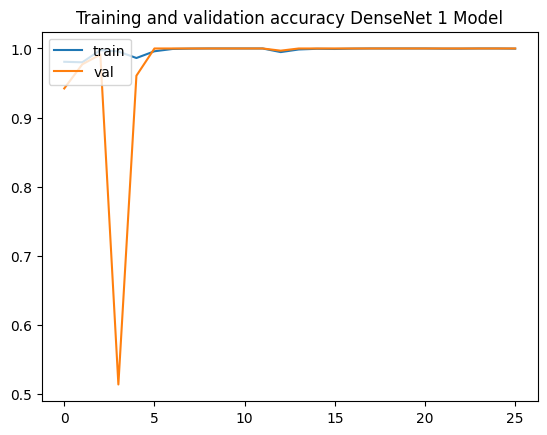

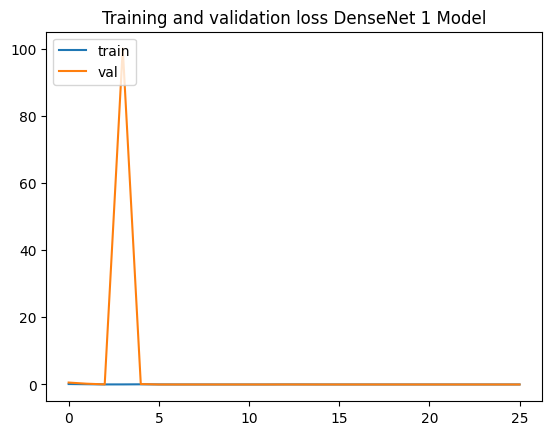

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet 1 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet 1 Model')
plt.legend(['train', 'val'], loc='upper left')

## DenseNet Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Cherry_DenseNet_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,300,418
Trainable params: 7,216,770
Non-trainable params: 83,648
_______________________________________

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9881
Epoch 1: val_accuracy improved from -inf to 0.72173, saving model to Cherry_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DenseNet_model2_Based_Non_Augmented\assets


211/211 [==============================] - 93s 396ms/step - loss: 0.0453 - accuracy: 0.9881 - val_loss: 2.2297 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9886
Epoch 2: val_accuracy improved from 0.72173 to 0.98729, saving model to Cherry_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DenseNet_model2_Based_Non_Augmented\assets


211/211 [==============================] - 81s 383ms/step - loss: 0.0325 - accuracy: 0.9886 - val_loss: 0.1621 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9967
Epoch 3: val_accuracy improved from 0.98729 to 0.99936, saving model to Cherry_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DenseNet_model2_Based_Non_Augmented\assets


211/211 [==============================] - 83s 391ms/step - loss: 0.0113 - accuracy: 0.9967 - val_loss: 6.1895e-04 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 4/100
211/211 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998
Epoch 4: val_accuracy did not improve from 0.99936
211/211 [==============================] - 42s 198ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0032 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 5/100
211/211 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9988
Epoch 5: val_accuracy improved from 0.99936 to 1.00000, saving model to Cherry_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DenseNet_model2_Based_Non_Augmented\assets


211/211 [==============================] - 80s 379ms/step - loss: 0.0025 - accuracy: 0.9988 - val_loss: 2.6244e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
211/211 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9967
Epoch 6: val_accuracy did not improve from 1.00000
211/211 [==============================] - 39s 184ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 3.1167e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
211/211 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9938
Epoch 7: val_accuracy did not improve from 1.00000
211/211 [==============================] - 39s 186ms/step - loss: 0.0244 - accuracy: 0.9938 - val_loss: 46.6809 - val_accuracy: 0.5089 - lr: 0.0010
Epoch 8/100
211/211 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9893
Epoch 8: val_accuracy did not improve from 1.00000
211/211 [==============================] - 40s 188ms/step - loss: 0.0309 - accuracy: 0.9893 - val_loss: 0.

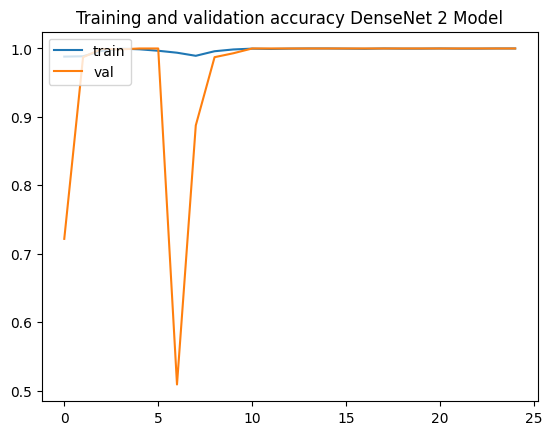

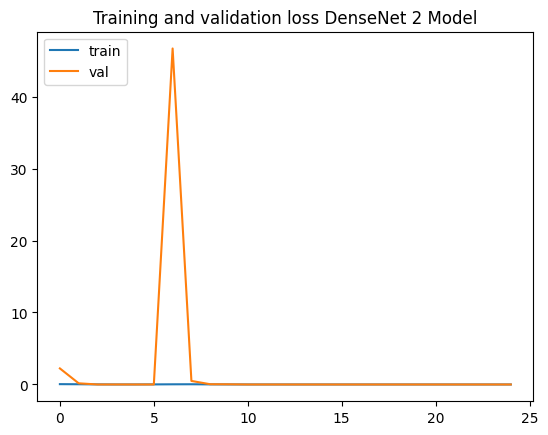

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet 2 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet 2 Model')
plt.legend(['train', 'val'], loc='upper left')